## Import Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import TimeSeriesSplit

import xgboost as xgb
from xgboost import XGBClassifier, XGBRegressor

import optuna

import joblib

import shap


## Import dataset

In [2]:
df = pd.read_csv('dataset.csv')

## Handling null values

In [3]:
df.isna().sum()

timestamp                0
hour_of_day              0
day_of_week              0
day_of_year              0
outside_temp             0
outside_humidity         0
weather_condition        0
occupancy_count          0
is_occupied              0
room_temp                0
power_kw                 0
fan_speed                0
ac_temp_setting      59002
ac_control_reason        0
dtype: int64

looks like the ac_temp_setting is null when the compressor is turned off, so we remain it as NaN

## Feature importance filter

In [4]:
# Make a copy of df
df_copy = df.copy()

# Ensure categorical types
for col in df_copy.select_dtypes(include=["object"]).columns:
    df_copy[col] = df_copy[col].astype("category")

# Split features and target
# Removing the non-predictors features after some testing
# Remove also timestamp as it is already have its features in the dataset
X = df_copy.drop(["is_occupied", "timestamp", "occupancy_count", "ac_control_reason", "power_kw", "fan_speed", "ac_temp_setting"], axis=1) 
y = df_copy["is_occupied"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Train
model = xgb.XGBClassifier(
    enable_categorical=True,
    tree_method="hist", 
    eval_metric="logloss",
    use_label_encoder=False
)

model.fit(X_train, y_train)

# Predictions
y_pred = model.predict(X_test)

# Evaluate
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)


d:\Github\campus_bms\machine_learning\models\occupancy_pred_model\venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [12:23:24] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Accuracy: 0.9287514863258026


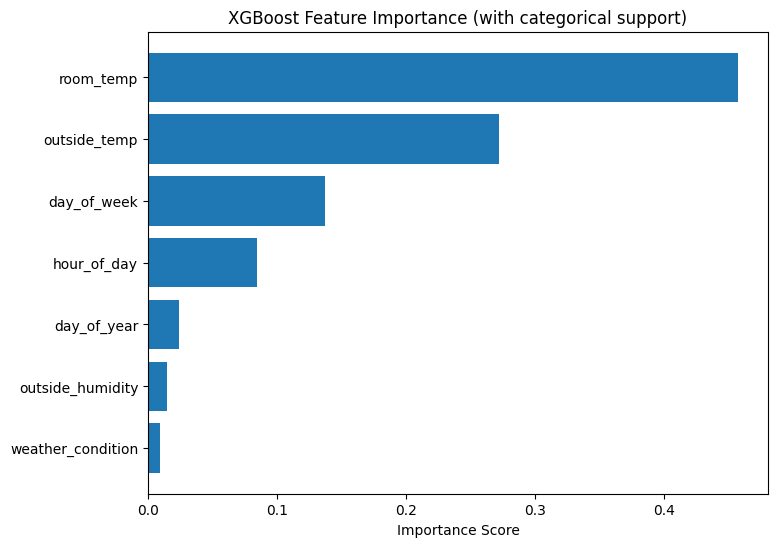

In [5]:
# --- 3. Extract and sort feature importances ---
importances = model.feature_importances_

feat_importance = pd.DataFrame({
    "Feature": X.columns,
    "Importance": importances
}).sort_values(by="Importance", ascending=True)  # sort ascending for barh

# --- 4. Plot nicely ---
plt.figure(figsize=(8, 6))
plt.barh(feat_importance["Feature"], feat_importance["Importance"])
plt.xlabel("Importance Score")
plt.title("XGBoost Feature Importance (with categorical support)")
plt.show()

After a bunch of testing, we realize that "occupancy_count", "ac_control_reason", "power_kw", "fan_speed", "ac_temp_setting" is dependent to "is_occupied", the target variable. So we remove them as they are not predictors. 

## Preprocessing

Dropping non-predictors columns

In [6]:
df = df.drop(["occupancy_count", "ac_control_reason", "power_kw", "fan_speed", "ac_temp_setting"], axis=1)

Feature engineering for timestamp

In [7]:
# convert to timestamp
df['timestamp'] = pd.to_datetime(df['timestamp'])

# Extract features
df['month_of_year'] = df['timestamp'].dt.month
df['is_weekend'] = (df['day_of_week'] >= 5).astype(int)

# Drop the raw timestamp column
df = df.drop('timestamp', axis=1)

Generating prediction window for the model to learn ahead occupancy

This would be the target variable which means "current_time + 30 min" will be occupied or not

In [8]:
# Predict if room will be occupied in next 30 minutes (6 rows if data is 5-min intervals)
prediction_window = 6  # 30 minutes ahead

df['future_occupied'] = (df['is_occupied'].shift(-prediction_window) == 1).astype(int)

# Drop last 6 rows (no future data)
df = df.iloc[:-prediction_window]

Lag features for previous occupancy

In [9]:
# Previous occupancy status
df['occ_lag1'] = df['is_occupied'].shift(1)
df['occ_lag2'] = df['is_occupied'].shift(2)
df['occ_lag3'] = df['is_occupied'].shift(3)

In [10]:
# Previous temperature
df['temp_lag1'] = df['room_temp'].shift(1)
df['temp_lag2'] = df['room_temp'].shift(2)

In [11]:
# Rolling averages
df['occ_rolling_mean_3'] = df['is_occupied'].rolling(window=3).mean()
df['temp_rolling_mean_3'] = df['room_temp'].rolling(window=3).mean()

Drop the NaN caused by the lag features for first few row

In [12]:
df = df.dropna(subset=["occ_lag1", "occ_lag2", "occ_lag3"]).reset_index(drop=True)

In [13]:
# Create cyclical features for time
def encode_cyclical(df, col, max_val):
    df[col + '_sin'] = np.sin(2 * np.pi * df[col] / max_val)
    df[col + '_cos'] = np.cos(2 * np.pi * df[col] / max_val)
    return df

df = encode_cyclical(df, 'hour_of_day', 24)
df = encode_cyclical(df, 'day_of_week', 7)

In [14]:
# Label encode weather condition
le_weather = LabelEncoder()
df['weather_encoded'] = le_weather.fit_transform(df['weather_condition'])

df = df.drop("weather_condition", axis=1)

In [15]:
df.describe()
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 105112 entries, 0 to 105111
Data columns (total 22 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   hour_of_day          105112 non-null  int64  
 1   day_of_week          105112 non-null  int64  
 2   day_of_year          105112 non-null  int64  
 3   outside_temp         105112 non-null  float64
 4   outside_humidity     105112 non-null  float64
 5   is_occupied          105112 non-null  int64  
 6   room_temp            105112 non-null  float64
 7   month_of_year        105112 non-null  int32  
 8   is_weekend           105112 non-null  int64  
 9   future_occupied      105112 non-null  int64  
 10  occ_lag1             105112 non-null  float64
 11  occ_lag2             105112 non-null  float64
 12  occ_lag3             105112 non-null  float64
 13  temp_lag1            105112 non-null  float64
 14  temp_lag2            105112 non-null  float64
 15  occ_rolling_mean_

In [16]:
df.head()

,hour_of_day,day_of_week,day_of_year,outside_temp,outside_humidity,is_occupied,room_temp,month_of_year,is_weekend,future_occupied,...,occ_lag3,temp_lag1,temp_lag2,occ_rolling_mean_3,temp_rolling_mean_3,hour_of_day_sin,hour_of_day_cos,day_of_week_sin,day_of_week_cos,weather_encoded
0,0,0,1,24.970486,65.615747,0,25.933911,1,0,0,...,0.0,25.949107,26.037660,0.0,25.973559,0.0,1.0,0.0,1.0,0
1,0,0,1,24.346744,62.063288,0,25.852349,1,0,0,...,0.0,25.933911,25.949107,0.0,25.911789,0.0,1.0,0.0,1.0,0
2,0,0,1,25.090406,68.249939,0,25.816791,1,0,0,...,0.0,25.852349,25.933911,0.0,25.867684,0.0,1.0,0.0,1.0,1
3,0,0,1,24.844961,68.059241,0,25.832636,1,0,0,...,0.0,25.816791,25.852349,0.0,25.833925,0.0,1.0,0.0,1.0,0
4,0,0,1,24.423887,60.000000,0,25.767326,1,0,0,...,0.0,25.832636,25.816791,0.0,25.805584,0.0,1.0,0.0,1.0,0


## Model training

In [17]:
X = df.drop(["is_occupied", "future_occupied"], axis=1)
y = df["future_occupied"]

# We will hold this test set back until the very end.
test_size_percentage = 0.2
split_index = int(len(X) * (1 - test_size_percentage))

# The first 80% of the data is for training and validation
X_train_val = X.iloc[:split_index]
y_train_val = y.iloc[:split_index]

# The final 20% of the data is our untouchable test set
X_test = X.iloc[split_index:]
y_test = y.iloc[split_index:]

print(f"Full dataset shape: {X.shape}")
print(f"Validation set shape: {X_train_val.shape}")
print(f"Test set shape: {X_test.shape}")

Full dataset shape: (105112, 20)
Validation set shape: (84089, 20)
Test set shape: (21023, 20)


In [18]:
def objective(trial):
    # Define the hyperparameter search space for this trial
    params = {
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
    }
    
    # Initialize the model with the suggested hyperparameters
    scale_pos_weight_value = (y_train_val == 0).sum() / (y_train_val == 1).sum()
    model = XGBClassifier(
        objective='binary:logistic',
        random_state=42,
        scale_pos_weight=scale_pos_weight_value,
        **params # Unpack the suggested parameters here
    )

    # Get a robust performance score using TimeSeriesSplit cross-validation
    tscv = TimeSeriesSplit(n_splits=5)
    score = cross_val_score(model, X_train_val, y_train_val, cv=tscv, scoring='f1', n_jobs=-1)
    
    # Return the average score for this set of hyperparameters
    return score.mean()

print("\nStart Optuna study to find the best hyperparameters")
# to maximize f1-score
study = optuna.create_study(direction='maximize')

# 50 trials for optuna
study.optimize(objective, n_trials=50)


# Results
print("\nHyperparameter search complete")
print(f"Number of finished trials: {len(study.trials)}")
print(f"Best trial's F1-score: {study.best_value:.4f}")
print("Best parameters found:")
for key, value in study.best_params.items():
    print(f"  {key}: {value}")

best_params = study.best_params


# Train the Final Model with the Best Parameters
print("\nTraining the final model with the best found parameters")
final_model = XGBClassifier(
    objective='binary:logistic',
    random_state=42,
    scale_pos_weight=(y_train_val == 0).sum() / (y_train_val == 1).sum(),
    **best_params # Use the best parameters found by Optuna
)
final_model.fit(X_train_val, y_train_val)


# Final Evaluation on the Held-Back Test Set
print("\nEvaluating the BEST model on the unseen Test Set")
final_predictions = final_model.predict(X_test)

print("\nFinal Performance Report on Test Set:")
print(classification_report(y_test, final_predictions, target_names=['Will be Empty', 'Will be Occupied']))

[I 2025-09-07 12:23:25,881] A new study created in memory with name: no-name-17d9fd80-2e29-44c2-819f-5a5d3794eca1



Start Optuna study to find the best hyperparameters


[I 2025-09-07 12:23:33,635] Trial 0 finished with value: 0.8117067371661617 and parameters: {'max_depth': 4, 'learning_rate': 0.0734008395818298, 'n_estimators': 608, 'subsample': 0.663815553782214, 'colsample_bytree': 0.7602495390971633}. Best is trial 0 with value: 0.8117067371661617.
[I 2025-09-07 12:23:43,073] Trial 1 finished with value: 0.7851062451427432 and parameters: {'max_depth': 4, 'learning_rate': 0.20420717625424237, 'n_estimators': 977, 'subsample': 0.6911548692563527, 'colsample_bytree': 0.9642835705118835}. Best is trial 0 with value: 0.8117067371661617.
[I 2025-09-07 12:23:46,138] Trial 2 finished with value: 0.8364001344172929 and parameters: {'max_depth': 8, 'learning_rate': 0.018203287395092495, 'n_estimators': 152, 'subsample': 0.8050199731945797, 'colsample_bytree': 0.7879426728584298}. Best is trial 2 with value: 0.8364001344172929.
[I 2025-09-07 12:23:49,029] Trial 3 finished with value: 0.8003975875856574 and parameters: {'max_depth': 7, 'learning_rate': 0.265


Hyperparameter search complete
Number of finished trials: 50
Best trial's F1-score: 0.8633
Best parameters found:
  max_depth: 3
  learning_rate: 0.026573550776103343
  n_estimators: 153
  subsample: 0.9143584949170526
  colsample_bytree: 0.800202821208244

Training the final model with the best found parameters

Evaluating the BEST model on the unseen Test Set

Final Performance Report on Test Set:
                  precision    recall  f1-score   support

   Will be Empty       0.90      0.86      0.88     11711
Will be Occupied       0.84      0.88      0.86      9312

        accuracy                           0.87     21023
       macro avg       0.87      0.87      0.87     21023
    weighted avg       0.87      0.87      0.87     21023



## Explanability of the model

## Export the model

In [19]:
joblib.dump(final_model, 'occupancy_pred.joblib')

['occupancy_pred.joblib']